In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob

In [2]:
# reading the data into data frames using pandas
"""
data_csv is a list of 10 data frames holding a [2,] list for each symboL
the first one (for example data_csv[i][0] ) is the name of the symbol and
the second one (for example data_csv[i][1] ) is the data assosiated to it
"""
data_csv = []
i = 0
for filename in glob.glob('data/*.csv'):
    data_csv.append([filename[5:len(filename)-4],pd.read_csv(filename).drop("<TICKER>",1)])
    i+=1
print(data_csv[0][0])
data_csv[0][1].head()

akhaber


,<DTYYYYMMDD>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<OPENINT>,<OPENINT>.1,<OPENINT>.2
0,20080809,1500.0,1500.0,1500.0,1500.0,2230300000,3.345450e+12,19267,0.0
1,20080810,1545.0,1545.0,1545.0,1545.0,64168880,9.914092e+10,4389,1500.0
2,20080811,1591.0,1591.0,1553.0,1553.0,3380431,5.378265e+09,501,1545.0
3,20080812,1599.0,1599.0,1556.0,1556.0,1062213,1.698478e+09,296,1553.0
4,20080813,1602.0,1602.0,1563.0,1563.0,2628987,4.211637e+09,649,1556.0


In [3]:
# fix the data frame on which we will do prediction
data_frame = 0
data = data_csv[data_frame][1][['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']]
data = data.values
# normilize the data
# data_mean = np.mean(data)
# data_std = np.std(data)
# data = (data - data_mean )/data_std

In [4]:
def turn_to_windows(dataset,window_size,start,end,target):
    start = window_size + start
    if(end is None):
        end = len(dataset)-window_size
    
    data = []
    labels = []
    for i in range(start,end):
        indices = range(i-window_size,i)
        data.append(dataset[indices])
        labels.append(dataset[i:i+target,4])
    return np.array(data),np.array(labels)

In [5]:
window_size = 21     # past window of information
target = 21          # number of future predictions
end = int(len(data)*0.8)   # number of train set examples
data_windowed,data_labels = turn_to_windows(data,window_size,0,end,target)
val_windowed,val_labels = turn_to_windows(data,window_size,end,None,target)

In [6]:
# predparing the data , in the form of tensors
train_data = tf.data.Dataset.from_tensor_slices((data_windowed,data_labels))
train_data = train_data.cache().shuffle(len(data_windowed)).batch(128).repeat()

val_data = tf.data.Dataset.from_tensor_slices((val_windowed,val_labels))
val_data = val_data.batch(128).repeat()

In [7]:
# creating the model
model = keras.models.Sequential()
model.add(keras.layers.LSTM(10,return_sequences=True,input_shape=data_windowed.shape[-2:]))
model.add(keras.layers.LSTM(5, activation='relu'))
model.add(keras.layers.Dense(21))
model.compile(optimizer=keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
# training the model
model.fit(train_data,epochs=5,steps_per_epoch=128,validation_data=val_data,validation_steps=50)

Train for 128 steps, validate for 50 steps
Epoch 1/5
128/128 [==============================] - 11s 89ms/step - loss: 10939672.5994 - val_loss: 11951451.4600
Epoch 2/5
 11/128 [=>............................] - ETA: 3s - loss: 10591607.3636

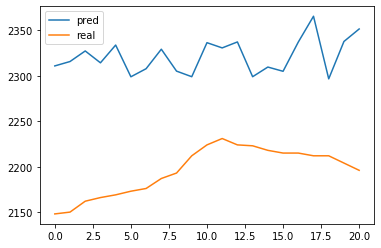

In [24]:
for x,y in val_data.take(1):
    pred=model.predict(x)
    plt.plot(pred[0],label='pred')
    plt.plot(y[1],label='real')
    plt.legend()